# **Section C**

In [1]:
#importing required modules and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2hsv, rgb2gray
from skimage.filters import sobel_h, sobel_v
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import xgboost as xgb
import pickle

# 1) EDA

In [42]:
#load labels and image name from label.csv
data = pd.read_csv('label.csv')
#check for missing values
print(data.isna().sum())

filename    0
label       0
dtype: int64


In [43]:
#check label wise distributions
class_counts = data['label'].value_counts()
print(class_counts)

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


In [47]:
#adding size for each image
def add_size(filename):
    img = imread('data/' + filename)
    h, w = img.shape[:2]
    return pd.Series([w, h])

data[['width', 'height']] = data['filename'].apply(add_size)
#print size distributions
print(data['width'].value_counts())
print(data['height'].value_counts())

width
275    3074
300    1038
262     746
183     703
259     646
       ... 
161       1
385       1
478       1
379       1
419       1
Name: count, Length: 269, dtype: int64
height
183    3310
168    1328
194     705
275     644
192     617
       ... 
293       1
116       1
102       1
318       1
312       1
Name: count, Length: 199, dtype: int64


In [48]:
#mean values for width and height
print("Mean value for width is ",np.mean(data['width']))
print("Mean value for height is ",np.mean(data['height']))

Mean value for width is  260.38103174603174
Mean value for height is  196.57357142857143


In [50]:
#adding aspect ratio for each image
data['aspectratio'] = data.apply(lambda row: round(row['width']/row['height'],2), axis=1)
print(data['aspectratio'].value_counts())

aspectratio
1.50    3111
1.79    1054
1.36     749
1.34     696
0.67     678
        ... 
3.11       1
2.85       1
2.77       1
2.92       1
3.49       1
Name: count, Length: 233, dtype: int64


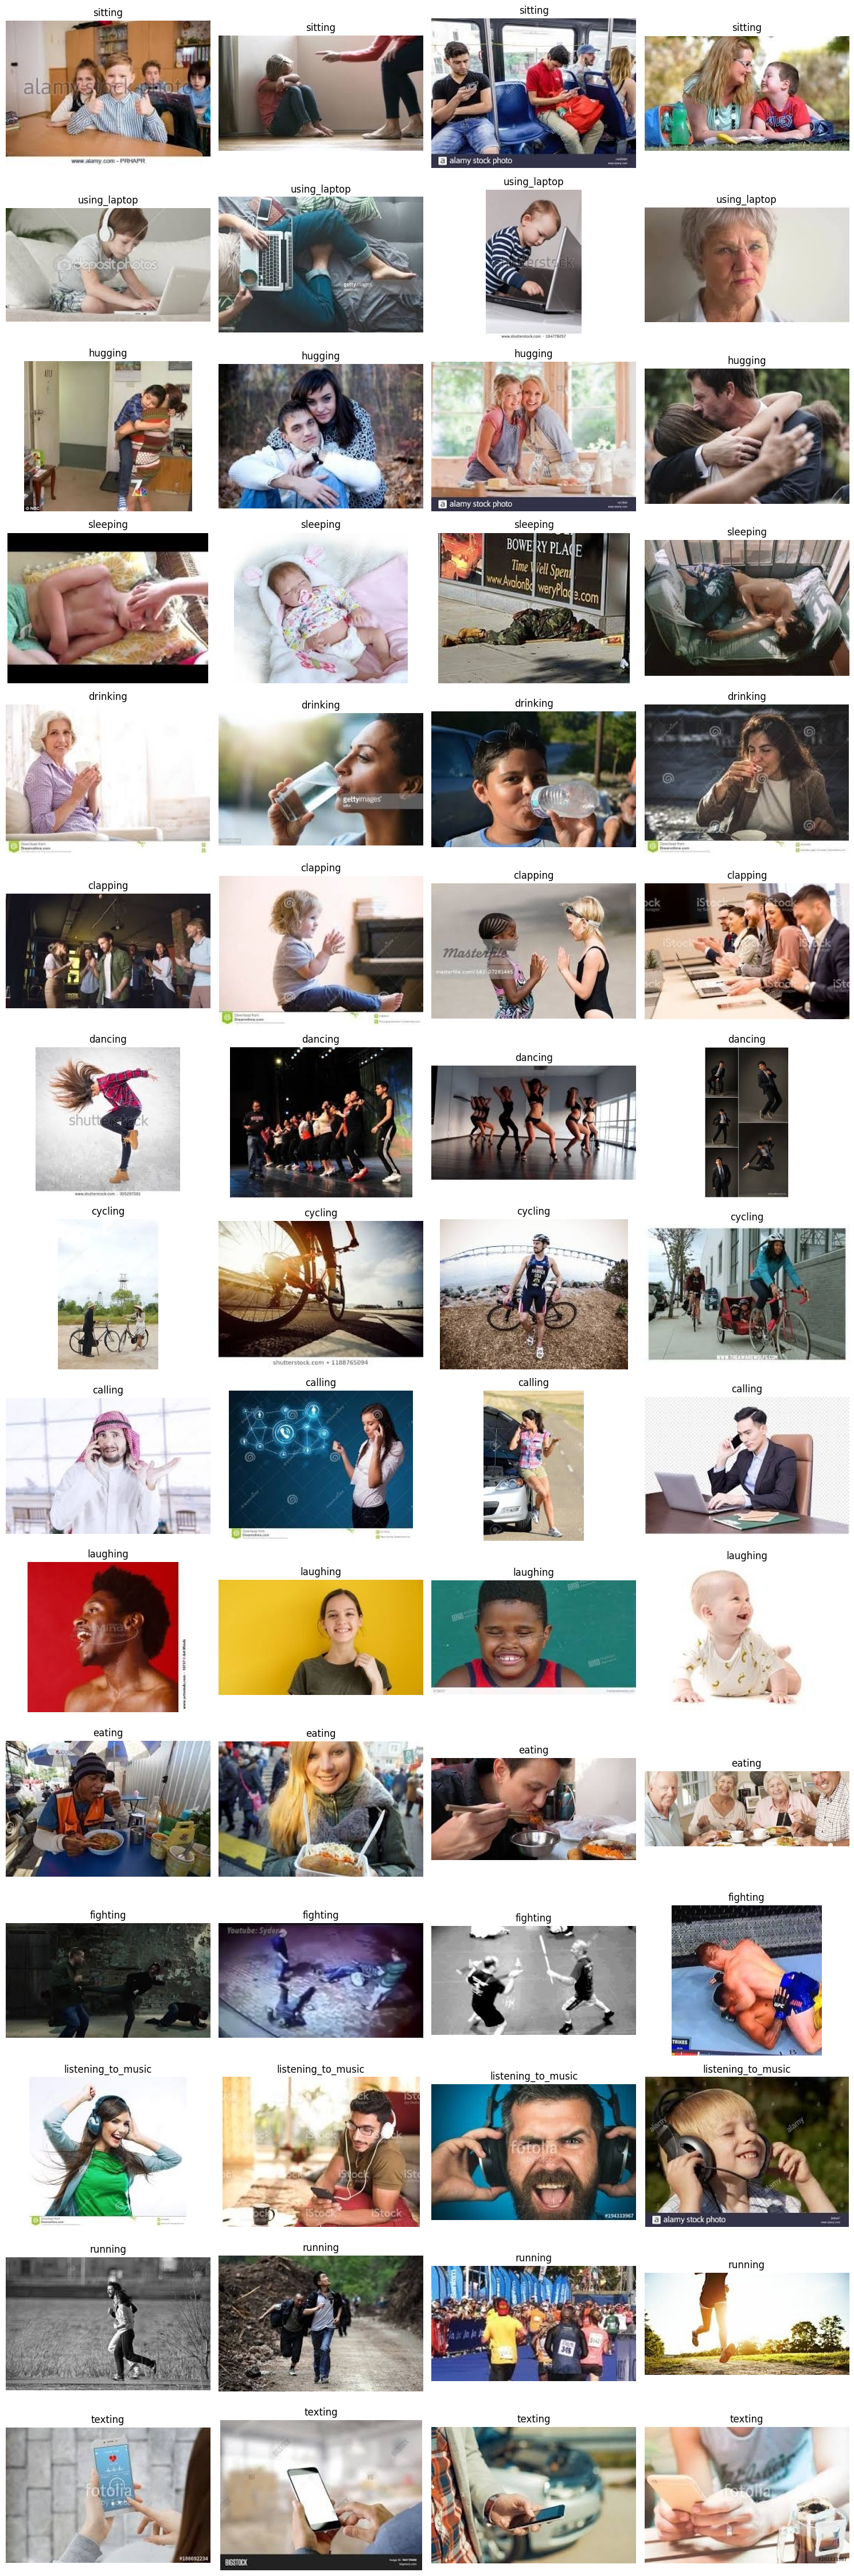

In [52]:
classes = data['label'].unique()
plt.figure(figsize=(15, len(classes)*3))
images_per_class = 4
for idx, cls in enumerate(classes):
    class_images = data[data['label'] == cls]['filename'].tolist()
    selected_images = random.sample(class_images, images_per_class)
    for j, name in enumerate(selected_images):
        img = imread('data/' + name)
        plt.subplot(len(classes), images_per_class, idx * images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
plt.tight_layout()
plt.show()

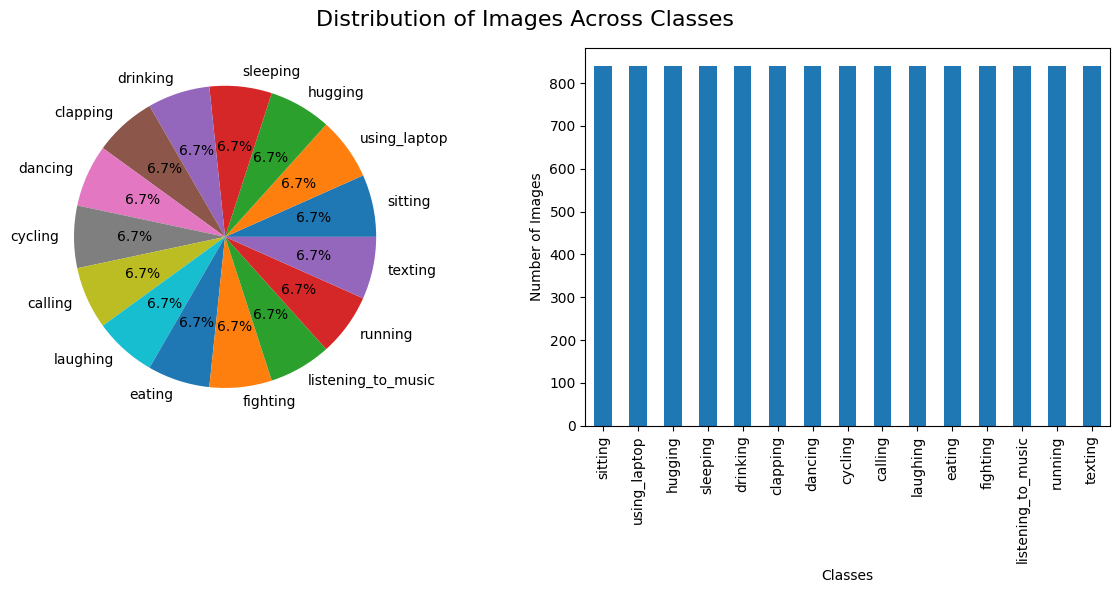

In [53]:
#plots to visualise class distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
class_counts.plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_ylabel('')

class_counts.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Number of Images')

fig.suptitle('Distribution of Images Across Classes', fontsize=16)
plt.tight_layout()
plt.show()

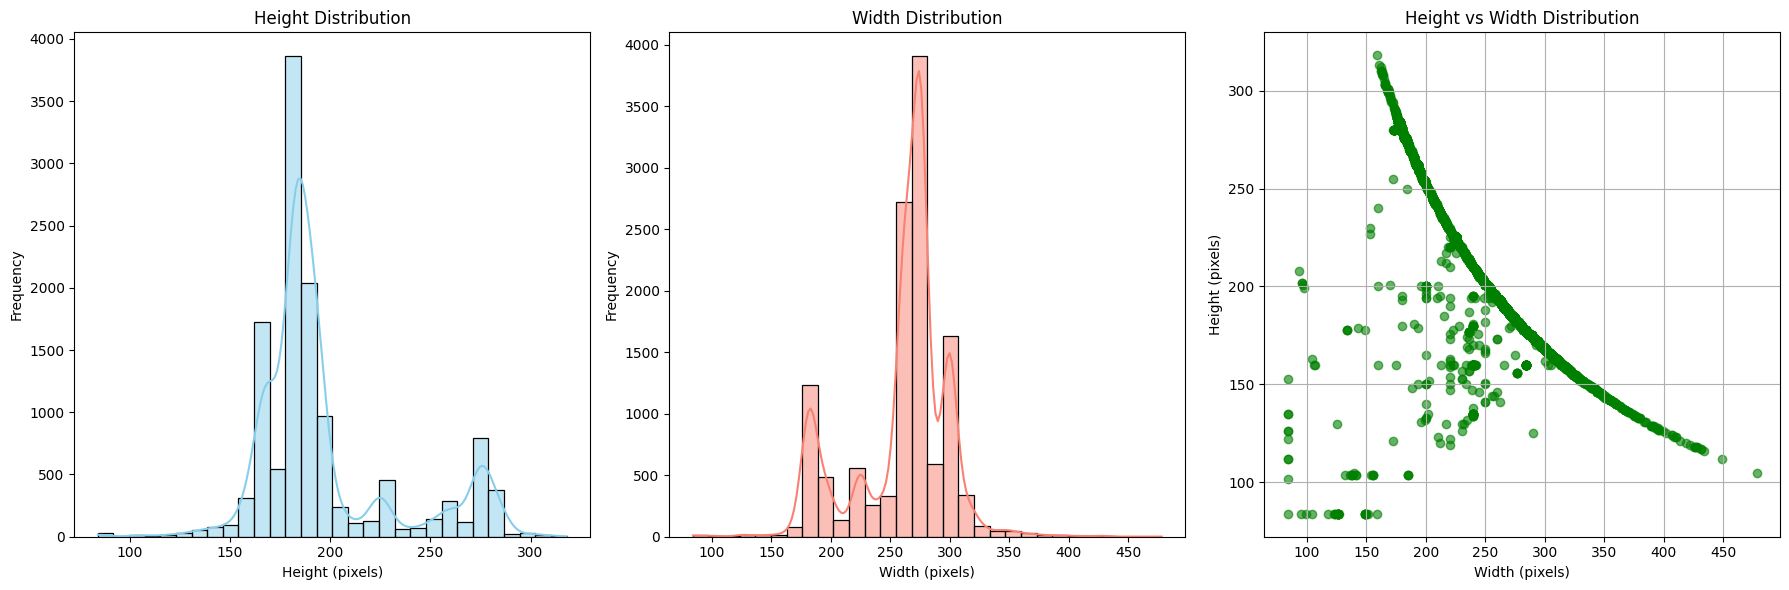

In [54]:
plt.figure(figsize=(18, 6))

#Height Distribution
plt.subplot(1, 3, 1)
sns.histplot(data['height'], bins=30, kde=True, color='skyblue')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

#Width Distribution
plt.subplot(1, 3, 2)
sns.histplot(data['width'], bins=30, kde=True, color='salmon')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

#Height vs Width Combined Distribution
plt.subplot(1, 3, 3)
plt.scatter(data['width'], data['height'], alpha=0.6, color='green')
plt.title('Height vs Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid()

plt.tight_layout()
plt.show()

# 2) Feature Extraction

In [4]:
#extract histogram of oriented gradients
def add_hog(gray_img):
    features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                        block_norm='L2-Hys', visualize=False, feature_vector=True)
    return np.array(features, dtype=np.float32)

In [5]:
#extract color histograms
def add_colhist(hsv_img, bins=(8, 8, 8)):
    hist, _ = np.histogramdd(hsv_img.reshape(-1, 3), bins=bins, range=[[0, 1], [0, 1], [0, 1]])
    if hist.sum() != 0:
        hist /= hist.sum()  #normalize the histogram
    return np.array(hist.flatten(), dtype=np.float32)

In [23]:
#extract local binary patterns
def add_lbp(gray_img, radius=2, n_points=2*8):
    lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize histogram
    return np.array(hist, dtype=np.float32)

In [24]:
#function to extract color moments from an image (in HSV color space)
def add_colmmnt(hsv_img):
    color_moments = []
    #calculate moments (mean, standard deviation, skewness) for each channel
    for i in range(3):  # 3 channels: H, S, V
        channel = hsv_img[:, :, i].flatten()
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean((channel - mean) ** 3) / (std ** 3 + 1e-8)  # Adding small value to avoid division by zero
        color_moments.extend([mean, std, skewness])
    return np.array(color_moments, dtype=np.float32)

In [25]:
#function to extract gradient features from an image
def add_gradients(gray_img):
    #compute the gradients using Sobel filter
    sobel_x = sobel_h(gray_img)  # Horizontal gradient
    sobel_y = sobel_v(gray_img)  # Vertical gradient
    #compute gradient magnitude
    gradient_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    #flatten the gradient features into a single vector
    gradient_features = gradient_magnitude.flatten()
    return np.array(gradient_features, dtype=np.float32)

In [26]:
#function to extract all features image by image
def extract_img_features(filename, dim=(64,64)):
    img = imread('data/' + filename) #read the image
    resized_img = resize(img, dim, anti_aliasing=True) #resize to uniform size
    gray_img = rgb2gray(resized_img) #apply grayscale
    hsv_img = rgb2hsv(img) #convert to HSV color space

    hog = add_hog(gray_img) #extract hog
    colhist = add_colhist(hsv_img) #extract color histograms
    lbp = add_lbp(gray_img) #extract lbp
    colmmnt = add_colmmnt(hsv_img) #extract color moments
    gradient = add_gradients(gray_img) #extract gradient features
    return pd.Series([hog, colhist, lbp, colmmnt, gradient])

In [75]:
#extract features from images
data[['hog', 'colhist', 'lbp', 'colmmnt', 'gradient']] = data['filename'].apply(extract_img_features)

#save labels and features to avoid recomputing later
data.to_pickle('labels.pkl')

c:\Users\rhima\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


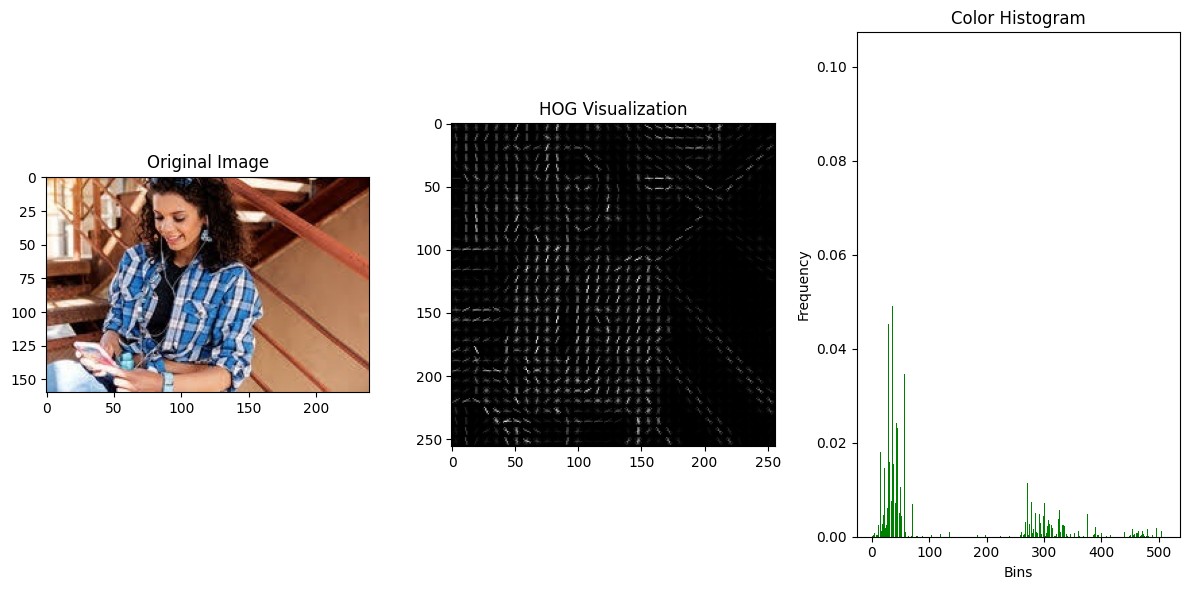

In [6]:
#feature visualization
img = imread('data/Image_1.jpg')
_, hog_img = hog(rgb2gray(resize(img, (256,256), anti_aliasing=True)), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                        block_norm='L2-Hys', visualize=True, feature_vector=True)
hist = add_colhist(rgb2hsv(img))

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

plt.subplot(1, 3, 3)
plt.bar(range(len(hist)), hist, color='g')
plt.title('Color Histogram')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3) Model Selection

In [14]:
data = pd.read_pickle('labels.pkl')
#select features to use for model trainnig
X = data.apply(lambda row: np.hstack((row['hog'], row['colhist'], row['lbp'], row['colmmnt'], row['gradient'])), axis=1)
y = data['label'] #label/target
X = pd.DataFrame(X.tolist())
print(X.shape[1]) #number of features for each image

#splitting into train:test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#reduce dimensions
pca = PCA(n_components=500)
X_train_r = pca.fit_transform(X_train_s)
X_test_r = pca.transform(X_test_s)

6399


In [100]:
#comparing various models with default parameters to decide a model to work upon
#naive bayes
nb_model = GaussianNB()
nb_model.fit(X_train_r, y_train)
y_pred_nb = nb_model.predict(X_test_r)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {acc_nb:.2f}')

#decision tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_r, y_train)
y_pred_dt = dt_model.predict(X_test_r)
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {acc_dt:.2f}')

#perceptron
perc_model = Perceptron(random_state=42)
perc_model.fit(X_train_r, y_train)
y_pred_perc = perc_model.predict(X_test_r)
acc_perc = accuracy_score(y_test, y_pred_perc)
print(f'Perceptron Accuracy: {acc_perc:.2f}')

#random forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_r, y_train)
y_pred_rf = rf_model.predict(X_test_r)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {acc_rf:.2f}')

Naive Bayes Accuracy: 0.17
Decision Tree Accuracy: 0.13
Perceptron Accuracy: 0.21
Random Forest Accuracy: 0.20


# 4) Best Model

Best RandomForestClassifier model in terms of accuracy

In [15]:
data = pd.read_pickle('labels.pkl')
#select relevant features
X = data.apply(lambda row: np.hstack((row['hog'], row['colhist'], row['lbp'])), axis=1)
X = pd.DataFrame(X.tolist())
y = data['label'] #label/target

#splitting into train:test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [33]:
model = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42, n_jobs=-1)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
acc = accuracy_score(y_pred, y_test)
print(acc)
# 0.3388888888888889

0.3388888888888889


Applying notions of boosting on RandomForestClassifier (using XGBClassifier)

In [2]:
data = pd.read_pickle('labels.pkl') 
X = data.apply(lambda row: np.hstack((row['hog'], row['colhist'], row['lbp'], row['gradient'])), axis=1)
X = pd.DataFrame(X.tolist())
y = data['label']

#perform label encoding of labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=15, n_estimators=500, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_s, y_train)

y_pred = xgb_model.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print('Accuracy with XGBoost: ', acc)
# 0.3884920634920635

In [ ]:
#save trained model
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [3]:
#load trained model
xgb_model = pickle.load(open('model.pkl', 'rb'))
y_pred = xgb_model.predict(X_test_s)
acc = accuracy_score(y_pred, y_test)
print(acc)
# 0.3884920634920635

0.3884920634920635
